In [80]:
import skrf as rf
from math import pi
from skrf.media.cpw import CPW
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from modeling.utils.resonators import cpw_cl_ll, resonator_kappa
from modeling.utils.network import assemble_network
from modeling.utils.qubits import e_charge, planck_h, phi0, get_Ic_from_Lj
from qucat import Network,L,J,C
from modeling.elements.smooth_capacitor.libraries.smooth_capacitor_library import digit_tee_ck_to_ground, get_ck
from scipy.optimize import fsolve
from modeling.qubits.clockmon.libraries.clockmon_library_2ports import clockmon_cqr_to_ground, clockmon_coupling_libraries
import scqubits as scq
from modeling.resonance_fit import ResFit

In [81]:
a = 10e-6
b = 6e-6
ep_r = 11.45
Z0 = CPW(w = a, s = b, ep_r = ep_r).z0[0].real

rr_freq_target = np.array([7.4e9, 7.2e9, 7.6e9])
l_rr = Z0*pi/(4*pi*rr_freq_target)
c_rr = 1/((2*pi*rr_freq_target)**2*l_rr)

cplr_freq_target = np.array([7.0e9, 6.8e9])
l_cr = Z0*pi/(4*pi*cplr_freq_target)
c_cr = 1/((2*pi*cplr_freq_target)**2*l_cr)

c_sigma_s = 91e-15
c_sigma_a = 100e-15

chi = 0.5e6
kappa_target = 1e6
qubit_freq_target = [5e9, 4.5e9, 5.1e9]

g_coupling_target = 90e6
Js1a = g_coupling_target**2*(qubit_freq_target[0] + qubit_freq_target[2] - 2*cplr_freq_target[0]) / (2*(qubit_freq_target[0] - cplr_freq_target[0]) * (qubit_freq_target[2] - cplr_freq_target[0]))
Js2a = g_coupling_target**2*(qubit_freq_target[1] + qubit_freq_target[2] - 2*cplr_freq_target[1]) / (2*(qubit_freq_target[1] - cplr_freq_target[1]) * (qubit_freq_target[2] - cplr_freq_target[1]))


def get_g(EC, Ej, c_coupling, c_r, wr):
    # From Manenti and Motta book
    g = EC/ (e_charge) * (Ej/EC/2)**(1/4) * c_coupling / (c_r) * np.sqrt(2*planck_h * wr * (c_r))
    return g

In [82]:
fl_traits = pd.read_csv("detection_device_2s_1a_00.csv").values[0][1:]
a = 10
b = 6

fl_traits[3] = 700
fl_traits[7] = 0
transmission_line_tee_points = [
    float(fl_traits[0]), # lp to input capacitor
    fl_traits[1] + (a + 2*b)/2, # input capacitor to tee
    fl_traits[2] + fl_traits[3] + fl_traits[4] + (a + 2*b), # tee to split point
    fl_traits[5] + (a + 2*b)/2, # split point to lp
    30 + fl_traits[6] + fl_traits[7] # split point to ground

]

In [83]:
fl_traits[3]

700

In [84]:
Lj_s1, Lj2, Lj_a, c_c_s1_a_sensing_side, c_c_s1_a_ancilla_side, c_c_s2_a_sensing_side, c_c_s2_a_ancilla_side, c_r_s1, c_r_s2, c_r_a = 10.21321317*1e-9, 12.49253732*1e-9,  9.00433897*1e-9,  4.7898494*1e-15,  4.98139003*1e-15, 5.18525301*1e-15,  5.12803936*1e-15,  3.16433829*1e-15,  3.77424908*1e-15,  3.51956952*1e-15
cks = np.array([6.15595685e-15, 6.41422813e-15, 5.91456431e-15])

In [85]:
resonator_capacitance = c_rr[0] -cks[0] -  c_r_s1
cfl = 6e-14
options = {
    "qubit_c": [c_sigma_s],
    "qubit_l": [Lj_s1],
    "readout_resonator_c": [resonator_capacitance],
    "readout_resonator_l": [l_rr[0]],
    "ck": [cks[0]],
    "cqr": [c_r_s1],
    "feedline_traits": transmission_line_tee_points,
    "cfl": cfl,
    "frequency": [1, 10],
    "n_points": 3001,
    "type": "feedline_resonator",
    "a": a,
    "b": b,
    "ep_r": ep_r
}

In [86]:
resonator_capacitance

2.596669032255214e-13

2-Port Network: '',  1.0-10.0 GHz, 3001 pts, z0=[50.+0.j 50.+0.j]


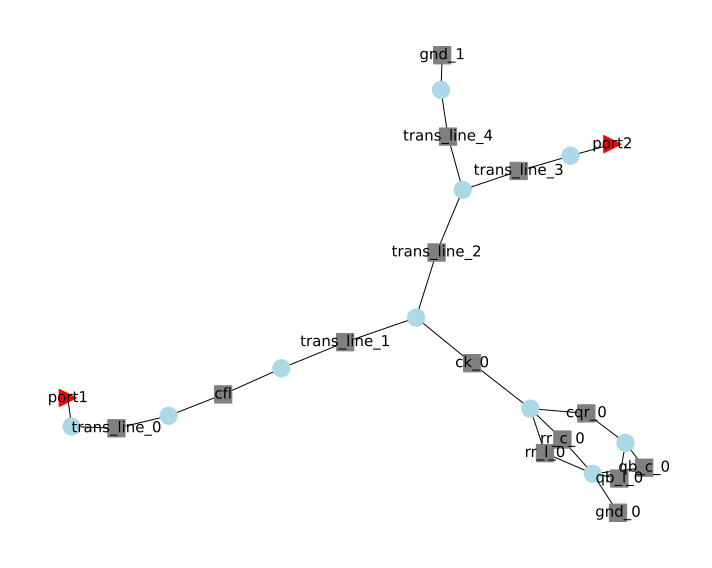

In [87]:
cnx = assemble_network(options)
cir = rf.Circuit(cnx)

cir.plot_graph(network_labels=True, network_fontsize=15,
               port_labels=True, port_fontsize=15,
               edge_fontsize=10)

# Get the resulting Network from the 'network' parameter:
ntw = cir.network
print(ntw)

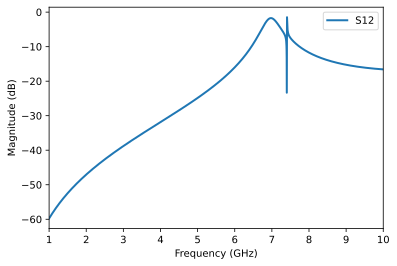

In [88]:
plt.figure(figsize = (6, 4))
ntw.plot_s_db(m=0, n=1, lw=2)